# 基于大气污染值的时序预测模型

## 🙏概述  
松山湖大气项目中利用遥感监测松山湖大气的污染，已经积累下了大量的具有时序信息的DSM数据，其中有CO、HCHO、NO2、O3、PM10、PM25、SO2等污染指标，在实际中常常需要预警下一个时序点的超标值，因此利用松山湖大气项目中积累下来的数据，利用深度学习模型，开发一个时序空间预测模型来预警未来的大气污染情况非常有必要。
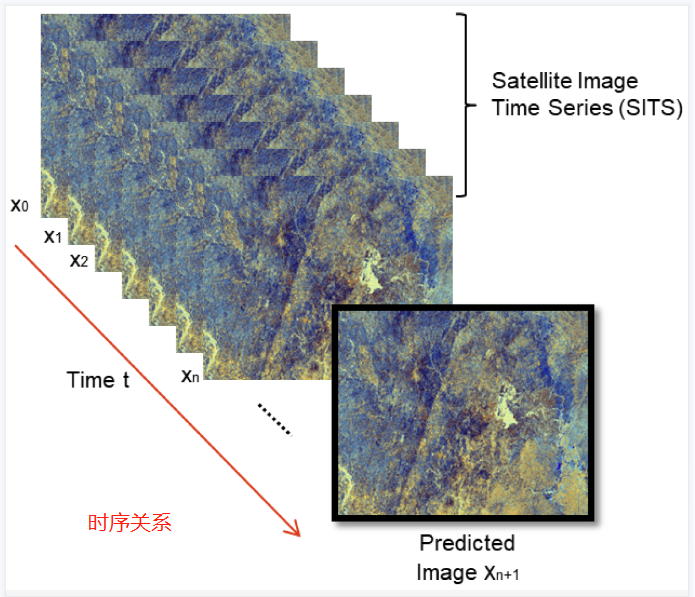

## 👀输入数据示例
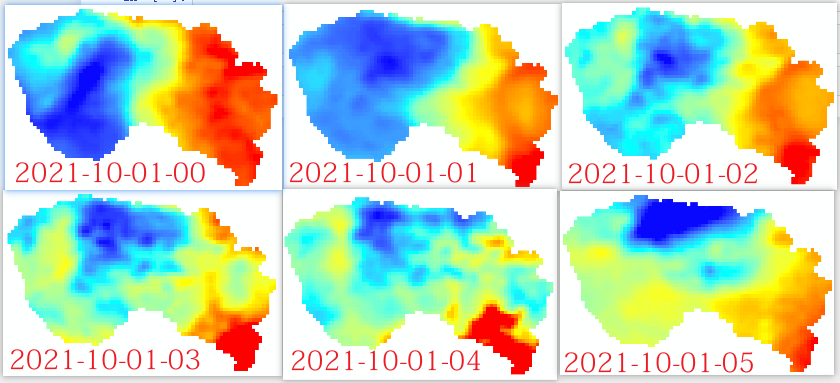

上图模拟的是松山湖地区2021年10月1日00时~05时的PM2.5变化情况，从蓝色到红色（低到高）  
从上图中可以看到大气的变化趋势

## 💘研究方法  

1. 清洗数据，将大气污染值数据先拉伸到0~255（注意去除极端值，构建二者的变换方程）  
2. 制作数据集，通过脚本制作时序变化数据  
3. 搭建convLSTM 模型  
4. 训练模型  
5. 测试模型

### 🍀清洗数据
1. 拉伸。找到数据正态分布的区域，通过截断和拉伸将数据的有效值投影到另一个空间中，这能帮助模型降低噪声干扰，加快拟合速度
2. 色彩映射。
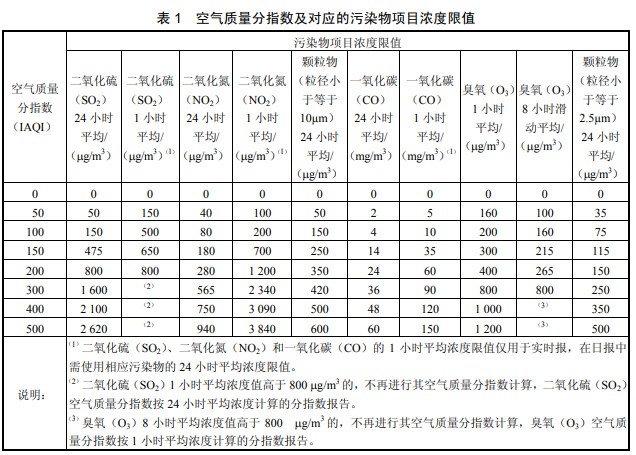

以CO为例，图上说明一小时变化中CO的最小值是0，最大值是150，为了保证数据粒度足够细，需要对原始影像数据做以下操作：  
* 将数据中 小于 0 的数据置0，大于150的数据置150；
* 将数据 乘以 100，将 0-150 的数据投影到 0-15000，以原始数据的0.01为变化粒度大小；
* 将数据由 float32 转换到 int16；
* 计算数据集中的平均值和标准差，用于数据标准化； (mean=42.91; std= 34.50)

O3 一小时的变化范围是 0-1200：
* 将数据中的 小于0的数据置0，大于1200的数据置1200；
* 将数据乘于10， 将 0-1200 的数据投影到 0-1200， 以原始数据的0.1 为变化粒度大小；

NO2 一小时的变化范围是 0-3840：
* 将数据中的 小于0的数据置0，大于3840的数据置3840；
* 将数据乘于10， 将 0-38400 的数据投影到 0-38400， 以原始数据的0.1 为变化粒度大小；

SO2 一小时的变化范围是 0-800：
* 将数据中的 小于0的数据置0，大于800的数据置800；
* 将数据乘于10， 将 0-800 的数据投影到 0-8000， 以原始数据的0.1 为变化粒度大小；

PM2.5 24小时的变化范围是 0-500：
* 将数据中的 小于0的数据置0，大于500的数据置500；
* 将数据乘于10， 将 0-500 的数据投影到 0-5000， 以原始数据的0.1 为变化粒度大小；

## 🚿 Load packages

In [1]:
import RasterIO_own
import os, glob, time
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
from loguru import logger

import torch
from torch import nn
from torch.nn import DataParallel as DP
from torch.utils.data import Dataset, DataLoader

SEED = 233
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 单张图片处理流程
co_tif = "2021100100.tif"
co_arr = RasterIO_own.readIMGByGDAL(co_tif, "array")
co_arr[co_arr<0] = 0
co_arr[co_arr>150] = 150
co_arr *= 100
co_arr = co_arr.astype("int16")
res_tif = "2021100100_res.tif"
RasterIO_own.writeTif(res_tif,co_arr)

### 🐨Load datasets

In [3]:
data_raw = np.load('O3_series20_size50_75.npy')
data_raw.shape
temp = data_raw[0]
print(data_raw.shape)

(4451, 20, 50, 75)


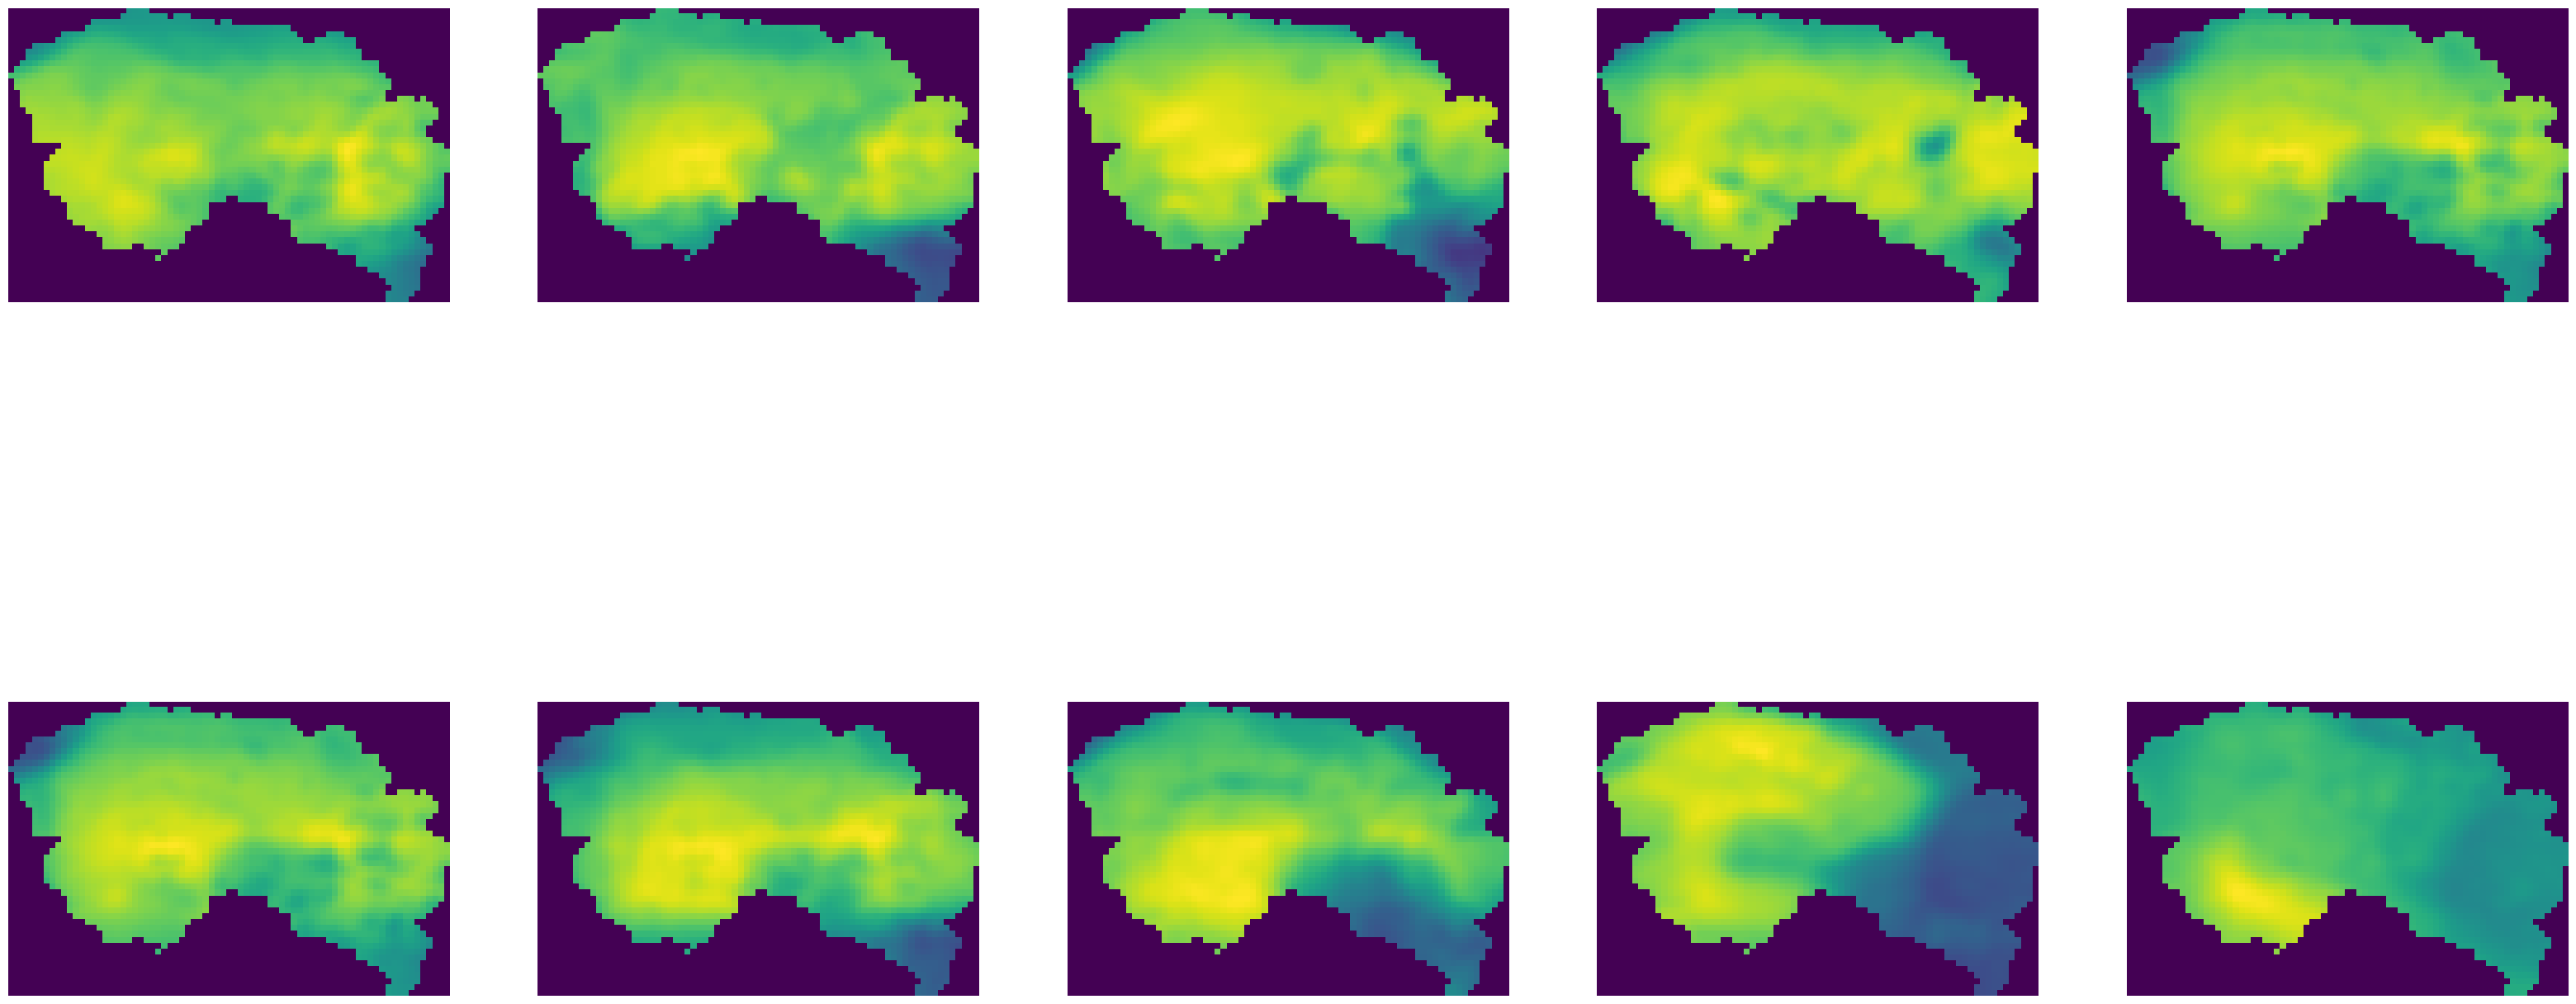

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(40, 20))
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(temp[i*4+j])
        axes[i, j].axis('off')

In [5]:
pollution_type = "O3"
transformer_own = {
    "CO": 15000.0,
    "O3": 12000.0,
    "NO2": 38400.0,
    "SO2": 8000.0,
    "PM25": 5000.0,
}

In [6]:
class AtmosphericPollution(Dataset):
    def __init__(self, data, mode, seed, seq_len, pollution_type):
        idx = np.arange(data.shape[0])
        np.random.seed(seed)
        np.random.shuffle(idx)
        L = len(idx)
        len_tr = int(0.7*L)
        len_val = int(0.1*L)
        len_te = L - len_tr - len_val
        logger.info(f'#total samples: {L}; #training samples: {len_tr}; #validation samples: {len_val}; #test samples: {len_te}')
        
        if mode == 'train':
            ind = idx[:len_tr]
        elif mode == 'val':
            ind = idx[len_tr:len_tr+len_val]
        elif mode == 'test':
            ind = idx[len_tr+len_val:]
        else:
            raise ValueError(f'Unknown mode type {mode}. Valid types are train, val and test.')
        
        self.len = len(ind)
        
        self.data = data[ind]
        self.seq_len = seq_len
        self.pollution_type = pollution_type
    
    def __getitem__(self, index):
        # 这里做标准化 mean=42.91; std= 34.50 CO 
#         image = self.data[index].astype(np.float32)
#         image -= np.array([42.91], np.float32)
#         image /= np.array([34.50], np.float32)
#         inputs = torch.tensor(image)
        inputs = torch.tensor(self.data[index].astype(np.float32)).float() / transformer_own[pollution_type]
        inputs = inputs.unsqueeze(1)
        return inputs[:self.seq_len], inputs[self.seq_len:]
    
    def __len__(self):
        return self.len

In [7]:
seq_len = 17

In [8]:
train_set = AtmosphericPollution(data_raw, 'train', SEED, seq_len, pollution_type)
val_set = AtmosphericPollution(data_raw, 'val', SEED, seq_len, pollution_type)
test_set = AtmosphericPollution(data_raw, 'test', SEED, seq_len, pollution_type)

2023-04-24 13:32:52.087 | INFO     | __main__:__init__:10 - #total samples: 4451; #training samples: 3115; #validation samples: 445; #test samples: 891
2023-04-24 13:32:52.214 | INFO     | __main__:__init__:10 - #total samples: 4451; #training samples: 3115; #validation samples: 445; #test samples: 891
2023-04-24 13:32:52.233 | INFO     | __main__:__init__:10 - #total samples: 4451; #training samples: 3115; #validation samples: 445; #test samples: 891


In [9]:
batch_size = 2
num_workers = 0

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1, num_workers=num_workers, pin_memory=True, drop_last=False)

In [10]:
for X, Y in val_loader:
    print(X.shape, Y.shape, X.min(), X.max(), Y.min(), Y.max())

torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.2212) tensor(0.) tensor(0.2111)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1121) tensor(0.) tensor(0.0624)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1338) tensor(0.) tensor(0.0834)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.2734) tensor(0.) tensor(0.1504)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1344) tensor(0.) tensor(0.0527)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.0641) tensor(0.) tensor(0.0272)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.0682) tensor(0.) tensor(0.0532)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.0931) tensor(0.) tensor(0.0978)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1198) tensor(0.

torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1358) tensor(0.) tensor(0.1072)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.2042) tensor(0.) tensor(0.1475)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1210) tensor(0.) tensor(0.0724)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1562) tensor(0.) tensor(0.0828)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1480) tensor(0.) tensor(0.0367)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1244) tensor(0.) tensor(0.0848)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1203) tensor(0.) tensor(0.1090)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.1330) tensor(0.) tensor(0.1557)
torch.Size([2, 17, 1, 50, 75]) torch.Size([2, 3, 1, 50, 75]) tensor(0.) tensor(0.2330) tensor(0.

# 🍍定义ConvLSTM模型

1. 定义ConvLSTM cell
2. 定义ConvLSTM block
3. 定义ConvLSTM encoder & decoder
4. 组成ConvLSTM 

### 🏀LSTM 模型图
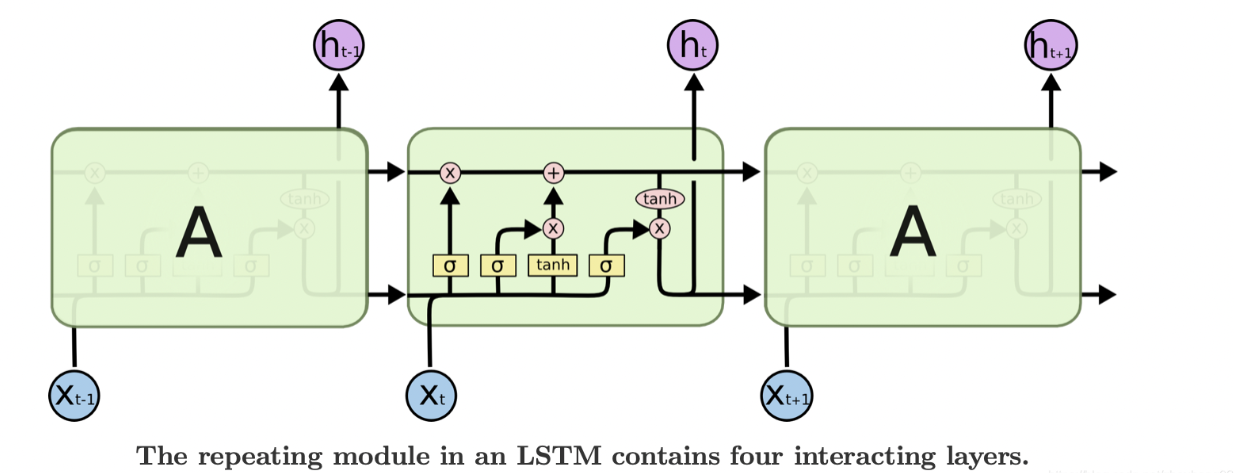

### ⚽️ConvLSTM 模型图
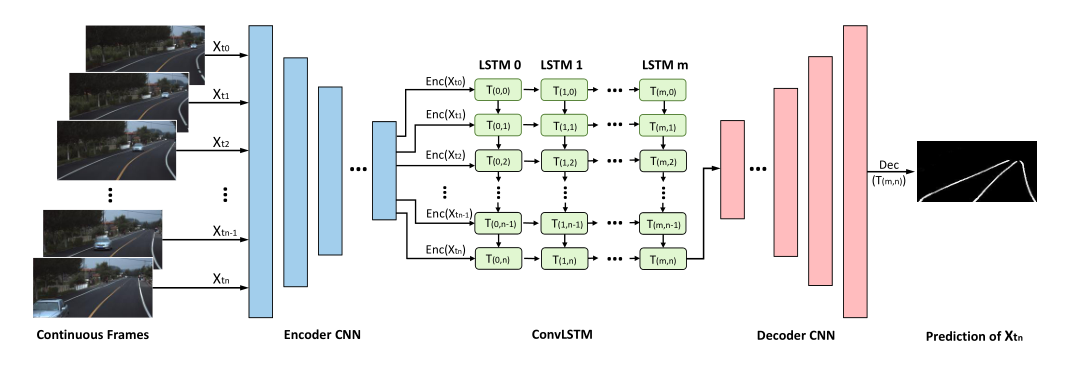

### 🐽 ConvLSTM cell
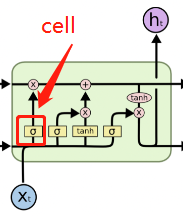

In [11]:
class ConvLSTMCell(nn.Module):
    '''
    ConvLSTM网络中的 基本门
    '''
    def __init__(self, channels_in, num_features, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.num_features = num_features
        
        self.conv = nn.Sequential(
            nn.Conv2d(channels_in + num_features, num_features*4, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.GroupNorm(num_features, num_features*4)
            # nn.BatchNorm2d(num_features*4)
        )
    
    def get_init_state(self, batch_size, height, width, device):
        return (
            torch.randn(batch_size, self.num_features, height, width, device=device) * 0.01,
            torch.randn(batch_size, self.num_features, height, width, device=device) * 0.01
        )
    
    def forward(self, inputs, hidden_state=None):
        """ 
        Parameters:
            inputs (tensor) -- shape: [N, C, H, W]
            hidden_state (tuple of tensors) -- (H, C). H's and C's shapes are [N, C1, H, W]
        """
        N, Ch, H, W = inputs.shape
        
        if hidden_state is None:
            H, C = self.get_init_state(N, H, W, inputs.device)
        else:
            H, C = hidden_state
            
        x_h = torch.cat([inputs, H], dim=1)
        
        gates = self.conv(x_h)
        
        in_gate, forget_gate, cell_gate, out_gate = torch.split(gates, self.num_features, dim=1)
        in_gate, forget_gate, out_gate = torch.sigmoid(in_gate), torch.sigmoid(forget_gate), torch.sigmoid(out_gate)
        cell_gate = torch.tanh(cell_gate)
        
        C = forget_gate * C + in_gate * cell_gate
        H = out_gate * torch.tanh(C)
        return H, C


# ConvLSTMCell 测试
net = ConvLSTMCell(1, 32, 3, 1, 1)  
x = torch.randn(8, 1, 50, 75)  
H, C = net(x)  
print(H.shape, C.shape)

### 🐮 ConvLSTM block
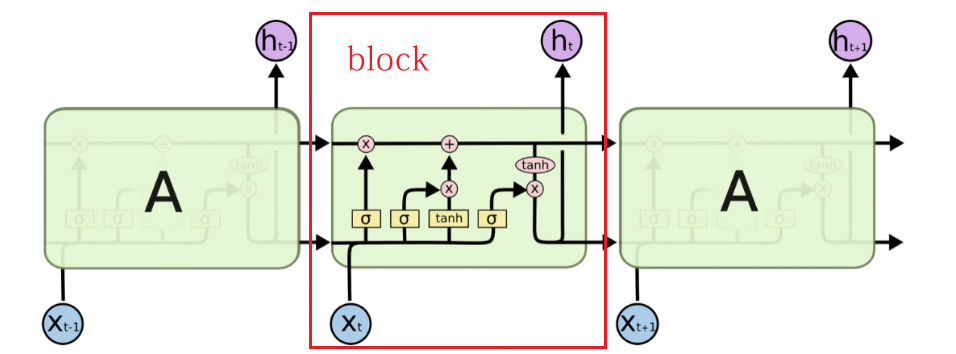

In [12]:
class ConvLSTMBlock(nn.Module):
    
    def __init__(self, channels_in, num_features, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.num_features = num_features
        self.net = ConvLSTMCell(channels_in, num_features, kernel_size, stride, padding)
    
    def get_init_state(self, batch_size, height, width, device):
        return (
            torch.randn(batch_size, self.num_features, height, width, device=device) * 0.01,
            torch.randn(batch_size, self.num_features, height, width, device=device) * 0.01
        )
     
    def forward(self, inputs):
        N, T, _, H, W = inputs.shape
        Hs = []
        
        H, C = self.get_init_state(N, H, W, inputs.device)
        
        for t in range(T):
            H, C = self.net(inputs[:, t, :, :, :], (H, C))
            Hs.append(H)
        
        return torch.stack(Hs).permute(1, 0, 2, 3, 4)

# ConvLSTMBlock 测试
net = ConvLSTMBlock(1, 64, 3, 1, 1)  
x = torch.randn(8, 15, 1, 50, 75)  
y = net(x)  
print(y.shape)  

### 🐵Encoder
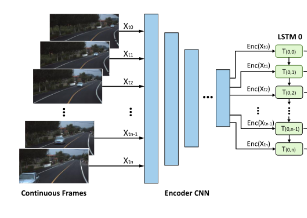

In [13]:
class ConvLSTMEncoder(nn.Module):
    """    
    Encoder of LSTM
    
    Parameters:
        num_features (list of int) -- number of output channels
    """
    def __init__(self, channels_in, num_features, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        layers = []
        for num_feature in num_features:
            layers.append(ConvLSTMBlock(channels_in, num_feature, kernel_size, stride, padding))
            channels_in = num_feature
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        outs = []
        for layer in self.layers:
            x = layer(x)
            outs.append(x)
        return outs


# ConvLSTMEncoder_测试
net = ConvLSTMEncoder(1, [64, 128, 64])  
x = torch.randn(8, 17, 1, 50, 75)  
outs = net(x)  
print(len(outs))  
print(outs[0].shape, outs[1].shape, outs[2].shape)  


### 🐴Decoder 
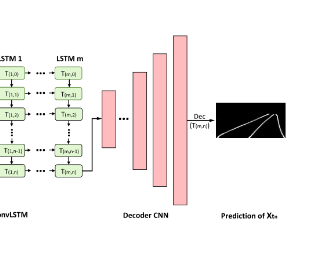

In [14]:
class ConvLSTMDecoder(nn.Module):
    '''
    Decoder of ConvLSTM
    '''
    def __init__(self, num_features_in, num_features_out, seq_len, pred_len, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        layers = []
        for feature_in, feature_out in zip(num_features_in, num_features_out):
            layers.append(ConvLSTMBlock(feature_in, feature_out, kernel_size, stride, padding))
        self.layers = nn.ModuleList(layers)
        
        self.fc_time = nn.Linear(seq_len, pred_len)
    
    def forward(self, inputs):
        out = 0
        for idx, layer in enumerate(self.layers):
            x = inputs[idx] + out
            out = layer(x)
        out_ = out.permute(0, 2, 3, 4, 1)
        out = self.fc_time(out_).permute(0, 4, 1, 2, 3)
        
        return out

# ConvLSTMDecoder_测试
num_features_in = [64, 128, 64]   
num_features_out = [128, 64, 1]    
net = ConvLSTMDecoder(num_features_in, num_features_out, 17, 2)  
out = net(outs)  
print(out.shape)  

### 🐪ConvLSTM

In [15]:
class ConvLSTM(nn.Module):
    """   
    
    """
    def __init__(self, channels_in, num_en_features, num_de_features, seq_len, pred_len):
        super().__init__()
        self.encoder = ConvLSTMEncoder(channels_in, num_en_features)
        self.decoder = ConvLSTMDecoder(num_en_features, num_de_features, seq_len, pred_len)
    
    def forward(self, inputs):
        return self.decoder(self.encoder(inputs))

# 测试ConvLSTM 模型
net = ConvLSTM(1, [64, 128, 64], [128, 64, 1], 18, 2)  
x = torch.randn(2, 18, 1, 50, 75)  
y = net(x)  
print(y.shape)  

## 📀 设置超参数

In [16]:
lr = 0.05
seq_len = 17
pred_len = 3

epochs = 100

In [17]:
net = ConvLSTM(1, [64, 128, 64], [128, 64, 1], seq_len, pred_len)
# net = ConvLSTM(1, [32, 64, 32], [64, 32, 1], seq_len, pred_len)
net = DP(net)
net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
best_loss = 1e9
logger.info('Training start!')

for epoch in range(1, epochs+1):

    tr_loss = 0.0
    net.train()
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        out = net(X)
        loss = criterion(out, Y)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
    tr_loss /= len(train_loader.dataset)
    
    val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            out = net(X)
            loss = criterion(out, Y)
            val_loss += loss.item()
    val_loss /= len(val_loader.dataset)

    if val_loss <= best_loss:
        best_loss = val_loss
        torch.save(net.state_dict(), 'O3_ConvLSTM_best.pth')
        
    logger.info(f'[{epoch}/{epochs}], training loss: {tr_loss:.9f}, validation loss: {val_loss:.9f}')        
logger.info('Training done!')

2023-04-24 13:33:26.117 | INFO     | __main__:<module>:2 - Training start!
2023-04-24 14:38:35.440 | INFO     | __main__:<module>:33 - [1/100], training loss: 0.047988, validation loss: 0.049099
2023-04-24 15:41:22.680 | INFO     | __main__:<module>:33 - [2/100], training loss: 0.047954, validation loss: 0.049083
2023-04-24 16:37:34.971 | INFO     | __main__:<module>:33 - [3/100], training loss: 0.047892, validation loss: 0.049071
2023-04-24 17:33:44.799 | INFO     | __main__:<module>:33 - [4/100], training loss: 0.047914, validation loss: 0.049063


## 🌄Test Phase

In [18]:
net.load_state_dict(torch.load('O3_Series20_Seq17_ConvLSTM_best.pth'))
net.eval()
outs = []
with torch.no_grad():
    for idx, (X, Y) in enumerate(train_loader):
        if idx == 0:
            X, Y = X.to(device), Y.to(device)
            out = net(X)

In [19]:
out = out.squeeze()
Y = Y.squeeze()
print(out.shape, Y.shape)

torch.Size([2, 3, 50, 75]) torch.Size([2, 3, 50, 75])


In [20]:
out.min(), out.max()

(tensor(-0.3572, device='cuda:0'), tensor(0.4150, device='cuda:0'))

In [21]:
print(out.min(), out.max())
out = out.cpu().numpy()
out = np.transpose(out, (1, 2, 0))
Y = Y.cpu().numpy()
Y = np.transpose(Y, (1, 2, 0))

tensor(-0.3572, device='cuda:0') tensor(0.4150, device='cuda:0')


ValueError: axes don't match array

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
for i in range(2):
    for j in range(3):
#         print(out[15:30, 30:50, j])
        axes[i, j].imshow(out[:, :, j])
        axes[i, j].axis('off')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
for i in range(2):
    for j in range(3):
        idx = i*2 + j
#         print(Y[15:30, 30:50, j])
        axes[i, j].imshow(Y[:, :, j])
        axes[i, j].axis('off')